# Propensity Scoring Explorations

In this notebook, I explore the propensity scoring from Recipe 1 of Ilya Katsov's The Theory and Practice of Enterprise AI.

I followed the path from the propensity scoring notebook with some additions:

* I did a bit of EDA on the data to better understand what is in it.
* I compared performance of Catboost versus LightGBM. Under WSL2, OpenCL is not passed through from the system, so LightGBM will be CPU-bound. This results in lengthy runtimes.
* Catboost and LightGBM appear to produce similar but not identical answers.
* I extracted and analyzed SHAP values for the boosted decision tree model.
* I wanted to compare how well a GAM would perform, which I carried out by passing to R. Notably, the GAM model performs well and is competitive against the other models.

## Setup and Preliminaries

This is copied from the original.

My base environment was NGC Tensorflow 23.03-tf2-py3. LightGBM needed to be built from [here](https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html). Additionally, tabulate and keras_tuner need to be installed.

In [1]:
#
# Import modules
#
import pandas as pd
import numpy as np
import lightgbm as lgb
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import platform

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend as K
import keras_tuner as kt

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

import time

print(f'Python {platform.python_version()} | TF {tf.__version__} | Keras {tf.keras.__version__}')

2023-04-28 20:26:28.062290: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python 3.8.10 | TF 2.11.0 | Keras 2.11.0


## Visualization and Helper Functions

Initially copied from original.

In [2]:
#
# Visualization and helper functions - from original
#
    
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(8, 8))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.fill_between(false_positive_rate, recall, color='r', alpha=0.025)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.show()
    
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="Wistia", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))
    
    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'
    
    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
def normalize(df, columns):
    for c in columns:
        df.loc[:, c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

## Data

The tensor-house-data repository sits alongside this one.

The file users.csv has columns meaning the following:

* uid - User ID
* location - user location (city or region)
* age - user age
* gender - user gender
* reg_channel - user's registration_channel
* reg_date - user's registration date
* outcome - binary flag whether user took a specific action

The file usage_logs.csv has columns meaning the following:

* date - activity date
* views - how many media items consumed
* previews - media items consumed
* duration - time spent in the application


In [3]:
#
# Import data
#
data_path = '../../tensor-house-data/promotions/media-dataset/'
df_users = pd.read_csv(data_path + 'users.csv.zip', compression='zip', index_col='uid', parse_dates=['reg_date'])
df_logs = pd.read_csv(data_path + 'usage_logs.csv.zip', compression='zip', index_col='uid', parse_dates=['date']).drop(columns=['items'])

print_df(df_users)
print_df(df_logs)
n_positives = df_users['outcome'].sum()
print(f'Profiles with positive oucomes: {n_positives} ({n_positives/len(df_users):.2%})')
print(f'Users without events: {len(set(df_users.index).difference(set(df_logs.index)))}')

+-------+------------+-------+----------+---------------+------------+-----------+
|   uid |   location |   age | gender   |   reg_channel | reg_date   |   outcome |
|-------+------------+-------+----------+---------------+------------+-----------|
|     0 |         15 |    17 | female   |             3 | 2014-10... |         1 |
|     1 |         13 |    40 | female   |             9 | 2006-05... |         0 |
|     2 |         14 |    23 | male     |             9 | 2007-03... |         1 |
|     3 |          1 |    19 | female   |             3 | 2014-11... |         1 |
|     4 |          1 |     0 | nan      |             9 | 2014-11... |         1 |
|     5 |         21 |    21 | male     |             9 | 2007-10... |         1 |
|     6 |          1 |     0 | nan      |             7 | 2014-04... |         1 |
|     7 |          5 |     0 | nan      |             9 | 2013-02... |         1 |
|     8 |         13 |    18 | female   |             9 | 2013-02... |         0 |
|   

In [4]:
# Comparing tabulate with standard pandas print
df_users

,location,age,gender,reg_channel,reg_date,outcome
uid,,,,,,
0,15,17,female,3,2014-10-21,1
1,13,40,female,9,2006-05-26,0
2,14,23,male,9,2007-03-25,1
3,1,19,female,3,2014-11-02,1
4,1,0,NaN,9,2014-11-08,1
...,...,...,...,...,...,...
8974,13,18,female,4,2015-11-08,0
8975,3,24,male,3,2014-05-24,1
8976,13,30,female,9,2008-12-30,0


In [5]:
df_logs.drop(columns='date').groupby('uid').agg('sum')

,views,previews,duration
uid,,,
0,2677,4600,86544
1,23010,7136,635905
2,52578,5000,1325654
3,5422,2072,145091
4,20754,7240,509117
...,...,...,...
8974,8165,2118,205343
8975,5573,1006,146466
8976,19750,6759,510172


In [6]:
#
# Basic feature engineering
#
profiles = df_users.join(df_logs.drop(columns='date').groupby('uid').agg('sum'), on='uid')
profiles['reg_days'] = (profiles['reg_date'].max() - profiles['reg_date']).dt.days
profiles = pd.get_dummies(profiles, columns=['gender'])
profiles.drop(columns=['reg_date'], inplace=True)
print_df(profiles)

+-------+------------+-------+---------------+-----------+---------+------------+------------------+------------+-----------------+---------------+
|   uid |   location |   age |   reg_channel |   outcome |   views |   previews |         duration |   reg_days |   gender_female |   gender_male |
|-------+------------+-------+---------------+-----------+---------+------------+------------------+------------+-----------------+---------------|
|     0 |         15 |    17 |             3 |         1 |    2677 |       4600 |  86544           |        856 |               1 |             0 |
|     1 |         13 |    40 |             9 |         0 |   23010 |       7136 | 635905           |       3926 |               1 |             0 |
|     2 |         14 |    23 |             9 |         1 |   52578 |       5000 |      1.32565e+06 |       3623 |               0 |             1 |
|     3 |          1 |    19 |             3 |         1 |    5422 |       2072 | 145091           |        844 

## Exploration

Katsov claims that the data are balanced. This appears to be true for the outcome.

(array([4423.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4556.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

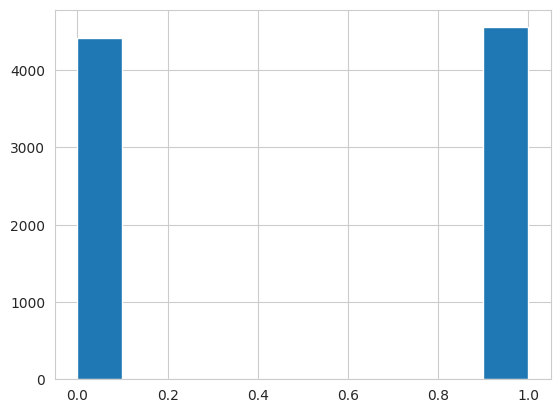

In [7]:
plt.hist(profiles['outcome'])

It does not appear to be true for the rest of the columns. The data are actually imbalanced. Hardly fatal, but it should be pointed out.

array([[<Axes: title={'center': 'location'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'reg_channel'}>],
       [<Axes: title={'center': 'outcome'}>,
        <Axes: title={'center': 'views'}>,
        <Axes: title={'center': 'previews'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'reg_days'}>,
        <Axes: title={'center': 'gender_female'}>],
       [<Axes: title={'center': 'gender_male'}>, <Axes: >, <Axes: >]],
      dtype=object)

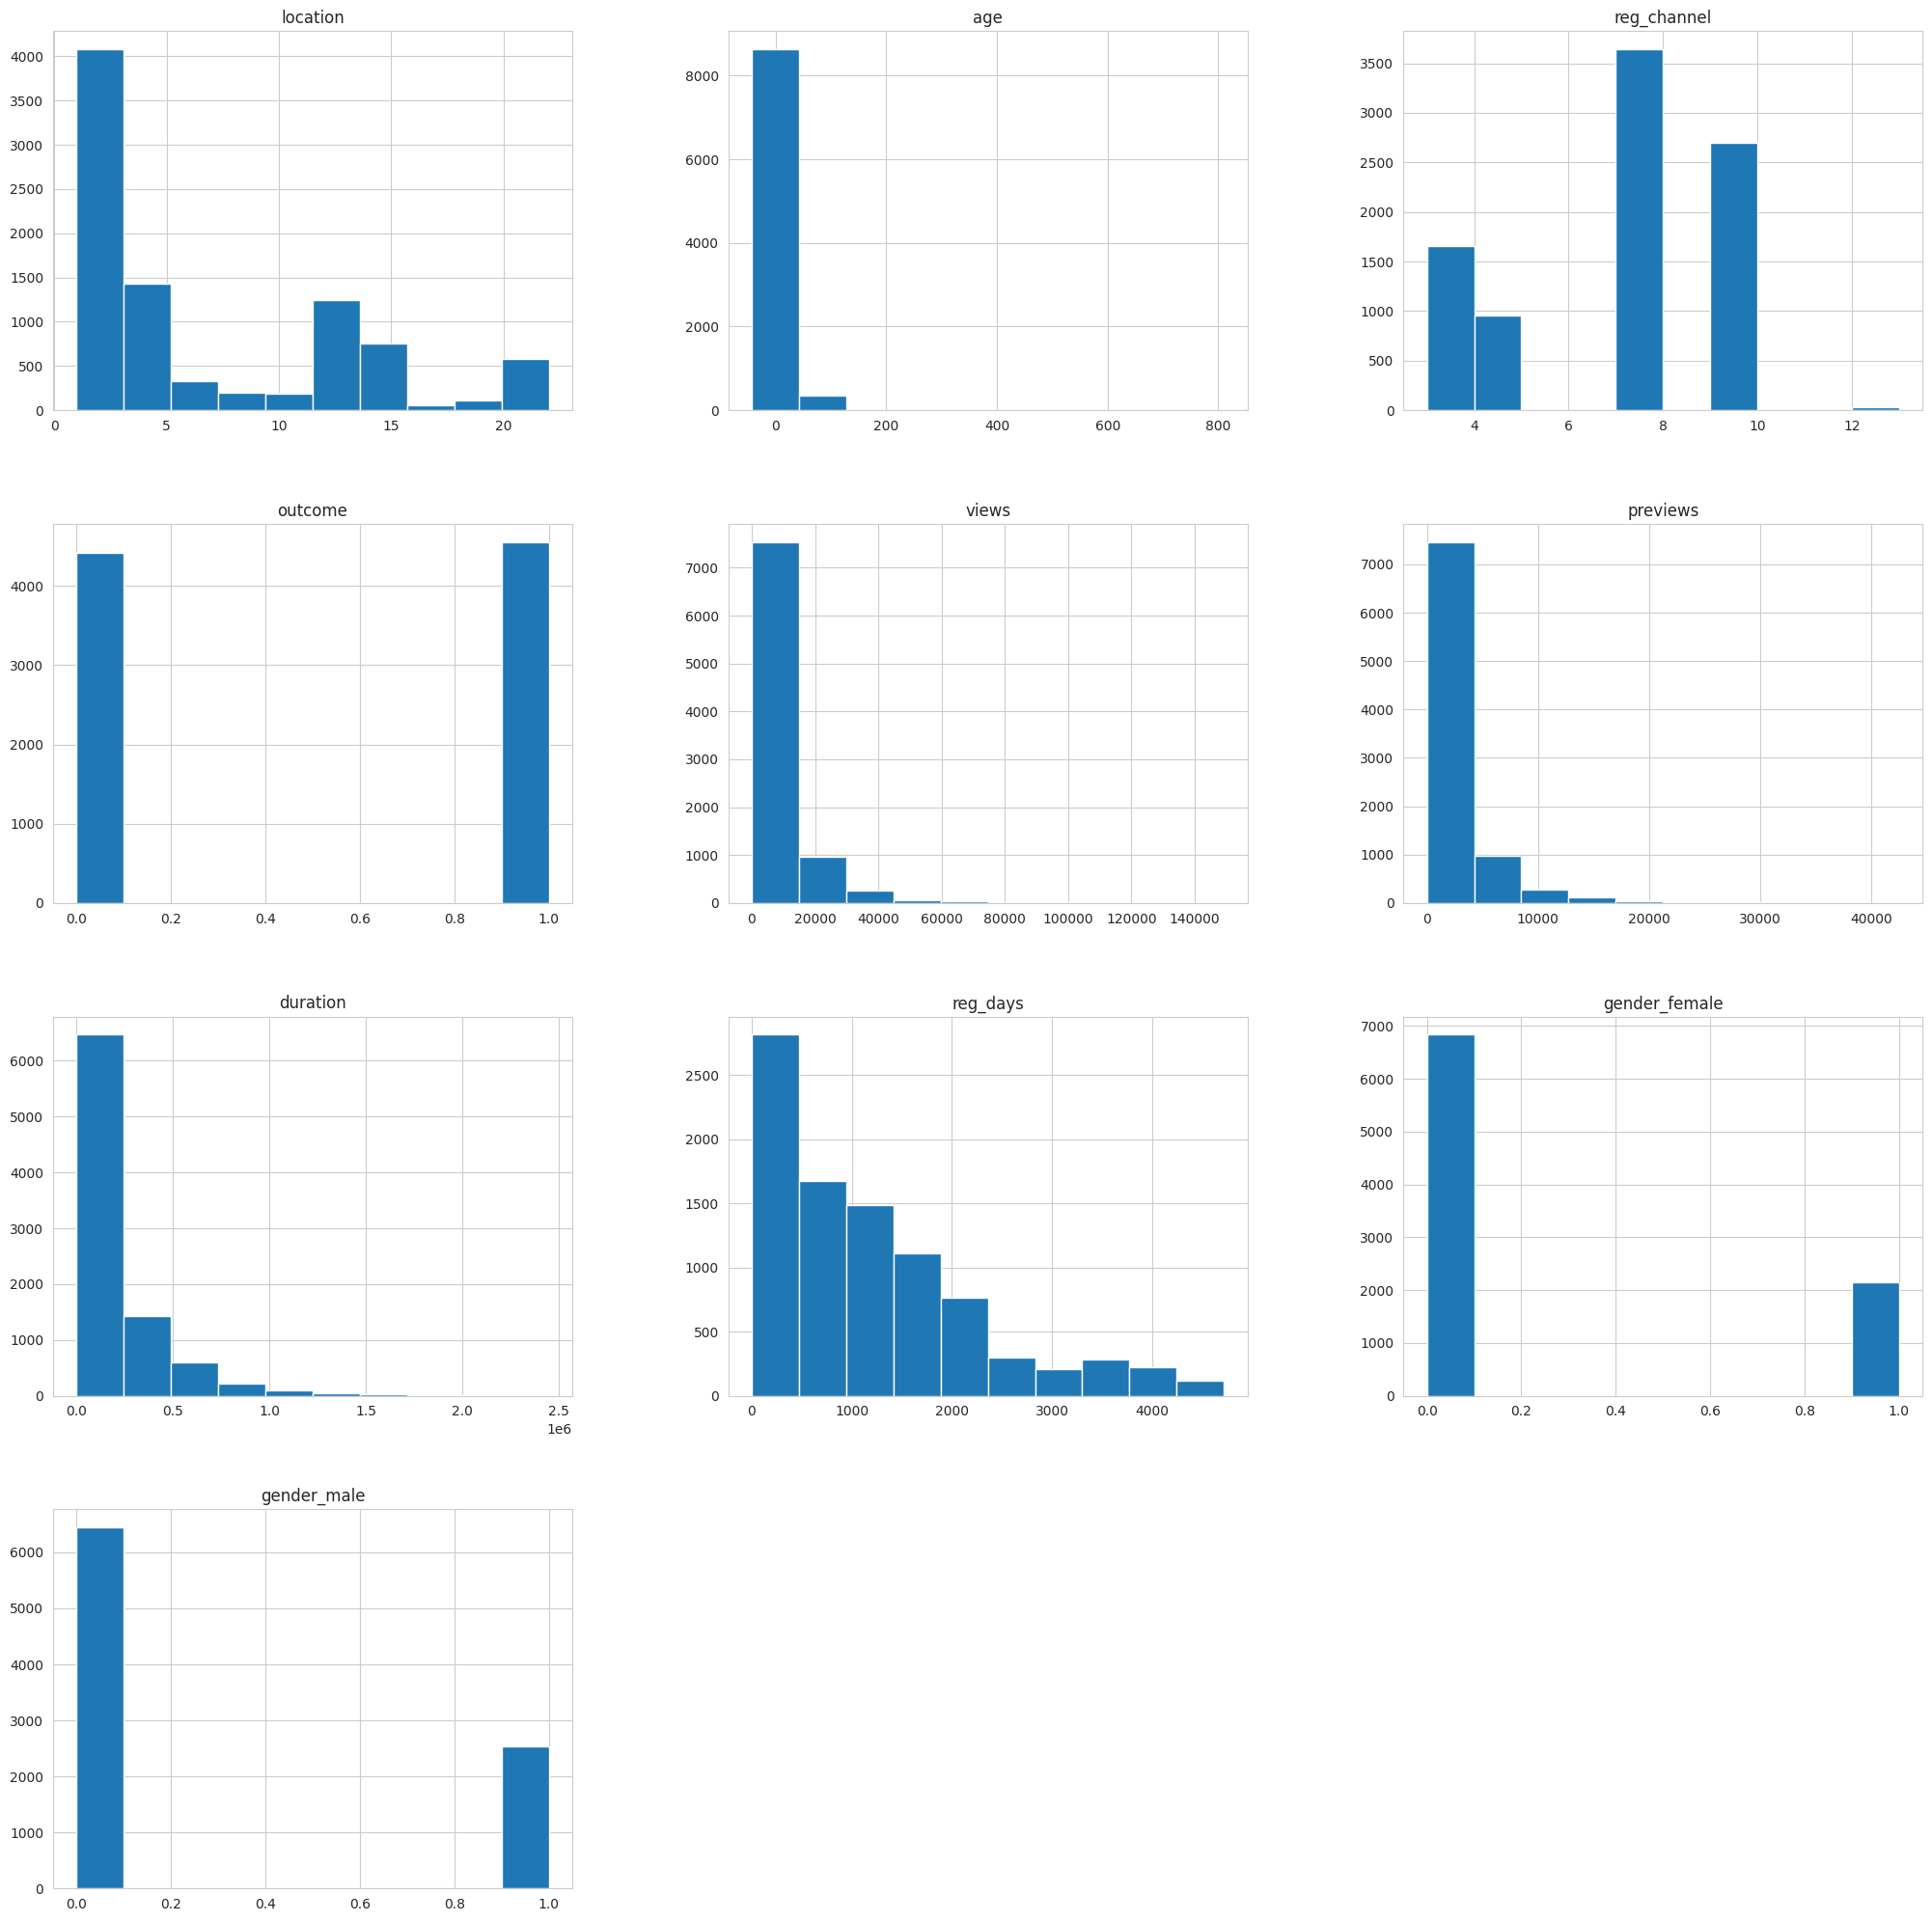

In [8]:
profiles.hist(figsize=(25,25))

<Axes: >

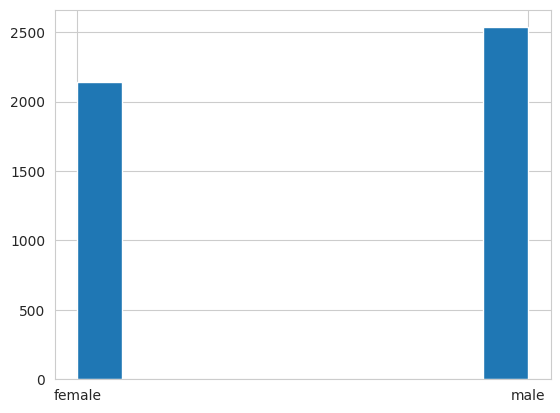

In [9]:
df_users['gender'].hist()

## Fitting gradient boosted decision tree with LightGBM

This is the baseline that Katsov used. For my own curiosity, I also compare CPU against GPU.

In [10]:
#
# Train test split
#
profiles.loc[profiles['age']==810,['age']] = np.NaN
x, y = profiles.drop(columns='outcome'), profiles['outcome']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## Fitting with CPU



In [26]:
tic = time.perf_counter()

train_data = lgb.Dataset(x_train, label=y_train)

# Model hyper-parameters
params = {'max_depth' : -1,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'num_class' : 1,
          'metric' : 'binary_error',
          'verbosity' : 0,
          'device' : 'cpu'
          }

# Parameters to optimize
gridParams = {
    'learning_rate': [0.02, 0.05, 0.07],
    'n_estimators': [8, 16, 32, 64, 128],
    'num_leaves': [20, 24, 28],
    'colsample_bytree' : [0.60, 0.65]
    }

# Create the classifier
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          device=params['device'])

mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)

# Search for optimal parameters
grid.fit(x_train, y_train)

# Print the best parameters values
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['n_estimators'] = grid.best_params_['n_estimators']

print(f'Fitting with params: {params}')

# Train the model on the selected parameters
lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=200)

print(f"CPU grid search and fit took {time.perf_counter() - tic:0.4f} seconds")

Fitting 4 folds for each of 90 candidates, totalling 360 fits
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 2548, number of negative: 2503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.491026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 5051, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504455 -> initscore=0.017819
[LightGBM] [Info] Start training from score 0.017819
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 2547, number of negative: 2503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.450360 seconds.
You can set `force_col_wise=true` to r

In [27]:
lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [28]:
#lgbm.save_model('lgbm_best.txt')

# Print the best parameters values
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

print(f'Fitting with params: {params}')


Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.07, 'n_estimators': 32, 'num_leaves': 28}
Best score: 0.6997384950525234
Fitting with params: {'max_depth': -1, 'num_leaves': 28, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'num_class': 1, 'metric': 'binary_error', 'verbosity': 0, 'device': 'cpu', 'n_estimators': 32}


The best parameters are on the edge of the grid search space. It also took about 38 minutes or so to carry out the grid search.

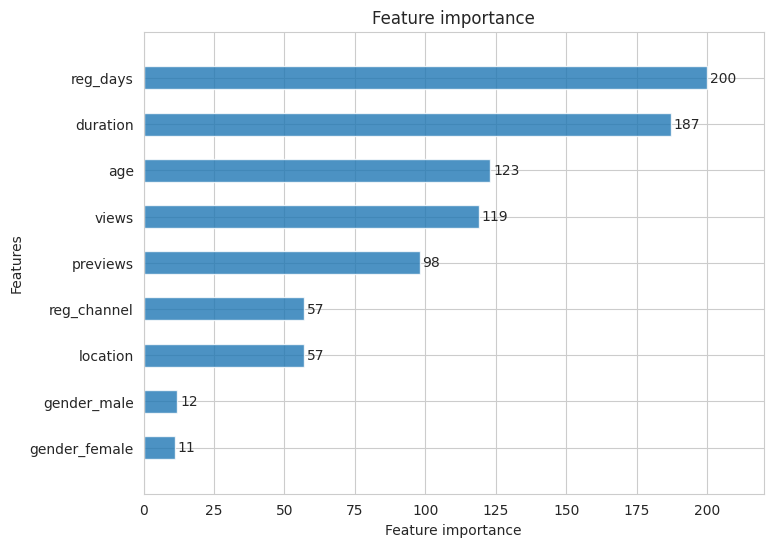

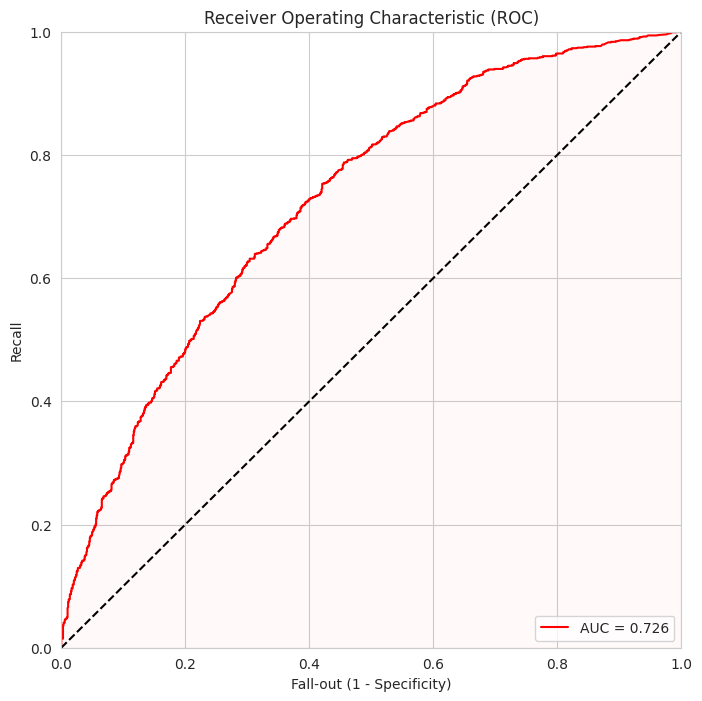

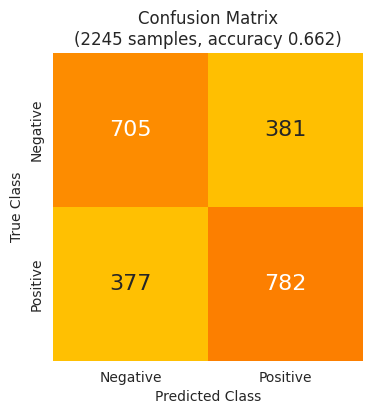

In [29]:
# 
# Plot accuracy measures and diagnostic information
#

# Predict on test set
predictions_lgbm_prob = lgbm.predict(x_test)

# Plot feature importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split',
                    height=0.5, color='#1f77b4', alpha=0.8, figsize=(8, 6))

# plot ROC
plot_roc(y_test, predictions_lgbm_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_lgbm_prob, ['Negative', 'Positive'])

## Catboost

Catboost allows for GPU usage on WSL2 instances. Thus, this would enable faster experimentation.

In [30]:
from catboost import CatBoostClassifier, Pool

In [31]:
# Model hyper-parameters
params = {
    #'max_depth' : -1,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
        #  'subsample_for_bin': 200,
          'subsample': 1,
        #  'subsample_freq': 1,
        #  'colsample_bytree': 0.8,
        #  'num_class' : 1,
        #  'metric' : 'binary_error',
        #  'verbosity' : 0,
          'task_type' : 'GPU'
          }

# Parameters to optimize
gridParams = {
    'learning_rate': [0.02, 0.05, 0.07],
    'n_estimators': [8, 16, 32, 64, 128,256]
    }

# Create the classifier
mdl = CatBoostClassifier(
          #boosting_type= 'gbdt',
          objective = 'Logloss',
          #n_jobs = 5, 
          #max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          #subsample_for_bin = params['subsample_for_bin'],
          #subsample = params['subsample'],
          #subsample_freq = params['subsample_freq'],
          task_type='GPU')

mdl.get_params().keys()

grid_search_results = mdl.grid_search(param_grid=gridParams,
            X=x_train,
            y=y_train,
            cv=4,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6897557	test: 0.6899806	best: 0.6899806 (0)	total: 32.4ms	remaining: 227ms
1:	learn: 0.6857103	test: 0.6865131	best: 0.6865131 (1)	total: 73.3ms	remaining: 220ms
2:	learn: 0.6814821	test: 0.6828383	best: 0.6828383 (2)	total: 115ms	remaining: 191ms
3:	learn: 0.6774526	test: 0.6797501	best: 0.6797501 (3)	total: 154ms	remaining: 154ms
4:	learn: 0.6737080	test: 0.6767434	best: 0.6767434 (4)	total: 194ms	remaining: 116ms
5:	learn: 0.6702176	test: 0.6738862	best: 0.6738862 (5)	total: 234ms	remaining: 77.9ms
6:	learn: 0.6670421	test: 0.6711845	best: 0.6711845 (6)	total: 273ms	remaining: 39ms
7:	learn: 0.6639615	test: 0.6686119	best: 0.6686119 (7)	total: 314ms	remaining: 0us
bestTest = 0.6686118621
bestIteration = 7
0:	loss: 0.6686119	best: 0.6686119 (0)	total: 418ms	remaining: 7.11s
0:	learn: 0.6848091	test: 0.6853732	best: 0.6853732 (0)	total: 41.6ms	remaining: 291ms
1:	learn: 0.6753854	test: 0.6773717	best: 0.6773717 (1)	total: 82ms	remaining: 246ms
2:	learn: 0.6660885	test: 0.6

In [32]:
#lgbm.save_model('lgbm_best.txt')
# Print the best parameters values
#grid_search_results
print(f'Best params: {grid_search_results["params"]}')
#print(f'Best score: {grid.best_score_}')

Best params: {'iterations': 256, 'learning_rate': 0.02}


In [33]:
cat = CatBoostClassifier(
          #boosting_type= 'gbdt',
          objective = 'Logloss',
          #n_jobs = 5, 
          #max_depth = params['max_depth'],
          #max_bin = params['max_bin'],
          #subsample_for_bin = params['subsample_for_bin'],
          #subsample = params['subsample'],
          #subsample_freq = params['subsample_freq'],
          learning_rate=grid_search_results["params"]["learning_rate"],
          iterations=500,
          task_type='GPU')

catm = cat.fit(
    x_train, y_train,eval_set=(x_test,y_test)
)

0:	learn: 0.6889904	test: 0.6894376	best: 0.6894376 (0)	total: 95.5ms	remaining: 47.6s
1:	learn: 0.6855053	test: 0.6865568	best: 0.6865568 (1)	total: 192ms	remaining: 47.7s
2:	learn: 0.6822427	test: 0.6838192	best: 0.6838192 (2)	total: 288ms	remaining: 47.6s
3:	learn: 0.6784755	test: 0.6805443	best: 0.6805443 (3)	total: 382ms	remaining: 47.4s
4:	learn: 0.6754610	test: 0.6779744	best: 0.6779744 (4)	total: 476ms	remaining: 47.2s
5:	learn: 0.6718016	test: 0.6747609	best: 0.6747609 (5)	total: 574ms	remaining: 47.3s
6:	learn: 0.6689144	test: 0.6724863	best: 0.6724863 (6)	total: 670ms	remaining: 47.2s
7:	learn: 0.6656829	test: 0.6697272	best: 0.6697272 (7)	total: 766ms	remaining: 47.1s
8:	learn: 0.6627261	test: 0.6671612	best: 0.6671612 (8)	total: 862ms	remaining: 47s
9:	learn: 0.6604551	test: 0.6653667	best: 0.6653667 (9)	total: 954ms	remaining: 46.8s
10:	learn: 0.6580606	test: 0.6635079	best: 0.6635079 (10)	total: 1.05s	remaining: 46.7s
11:	learn: 0.6552518	test: 0.6610598	best: 0.6610598 

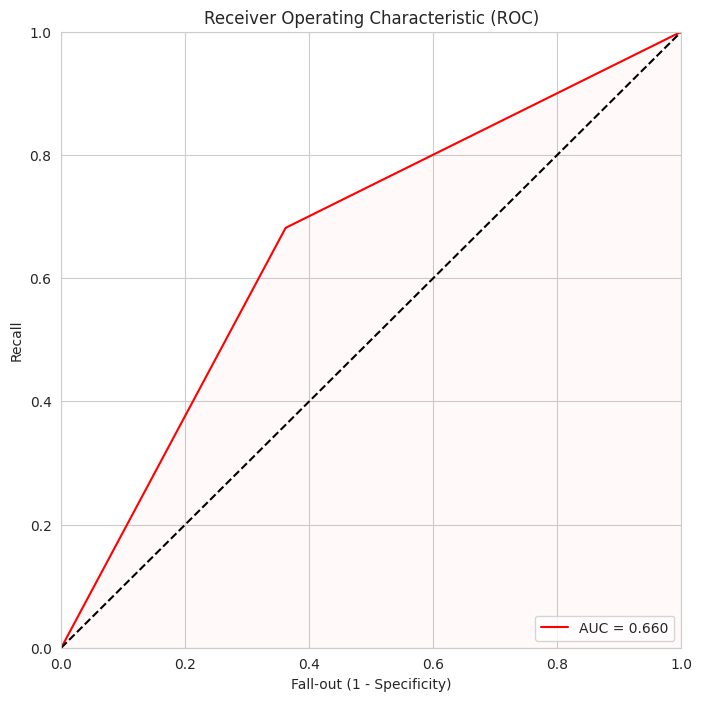

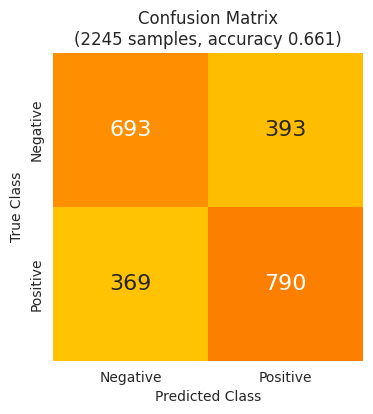

In [34]:
# 
# Plot accuracy measures and diagnostic information
#

# Predict on test set
predictions_cat_prob = cat.predict(x_test)

# plot ROC
plot_roc(y_test, predictions_cat_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_cat_prob, ['Negative', 'Positive'])

## SHAP values

Examining SHAP values of Catboost

In [35]:
import shap

# Fits the explainer
explainer = shap.Explainer(catm.predict, x_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_train)

Exact explainer: 6735it [01:26, 70.82it/s]                          


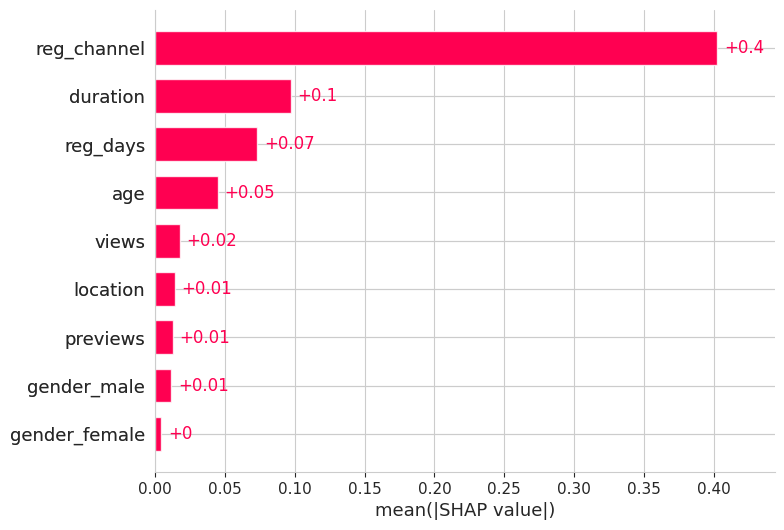

In [36]:
shap.plots.bar(shap_values)

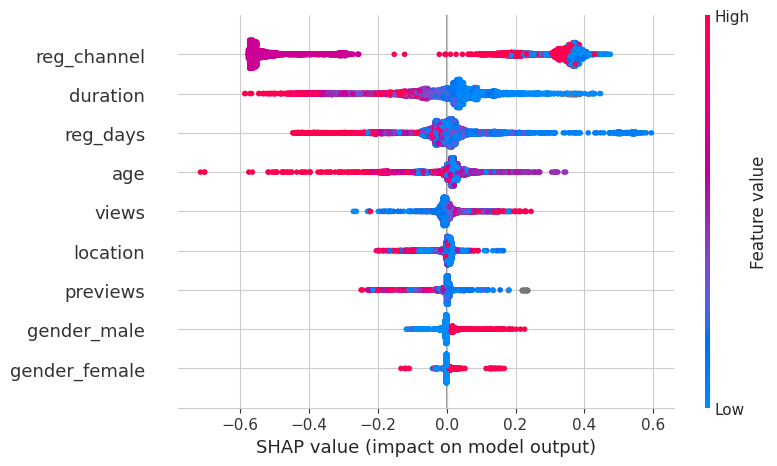

In [37]:
shap.plots.beeswarm(shap_values)

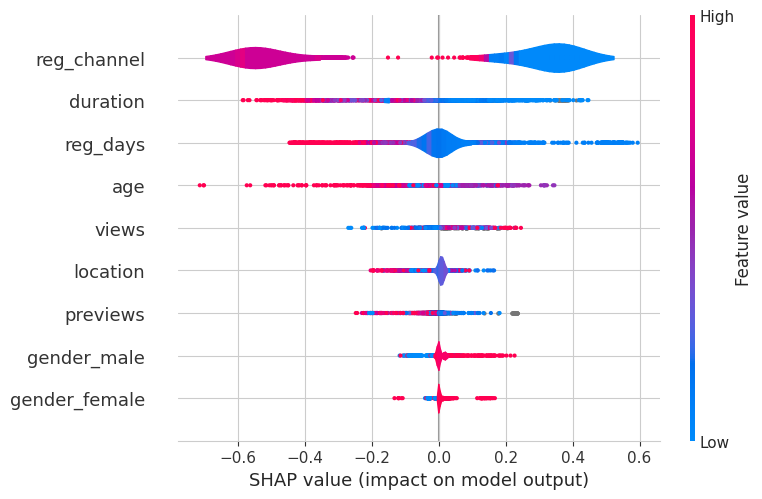

In [38]:
shap.summary_plot(shap_values, plot_type='violin')

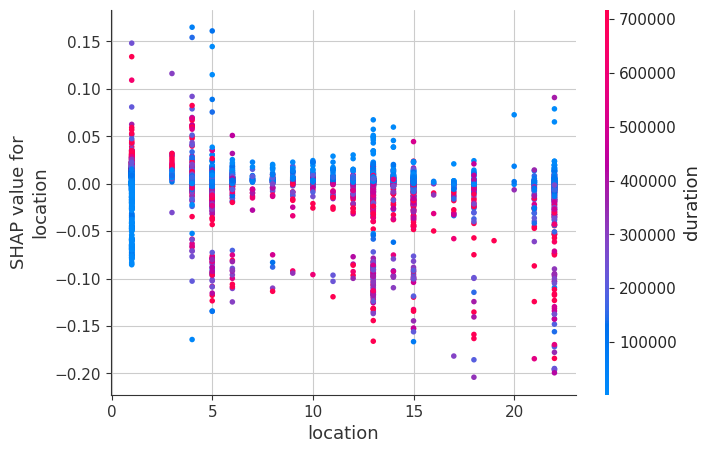

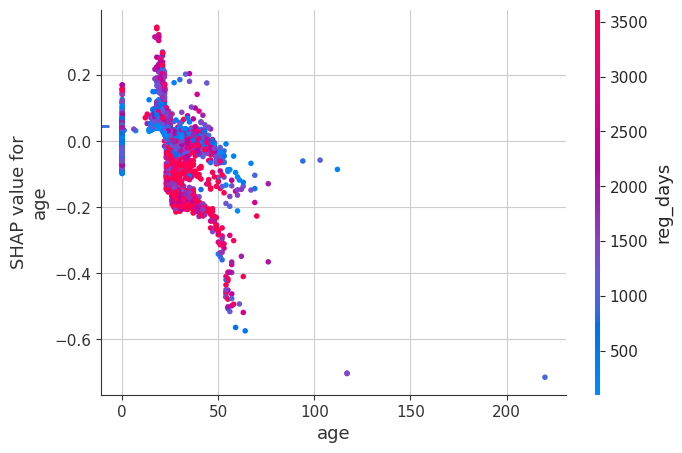

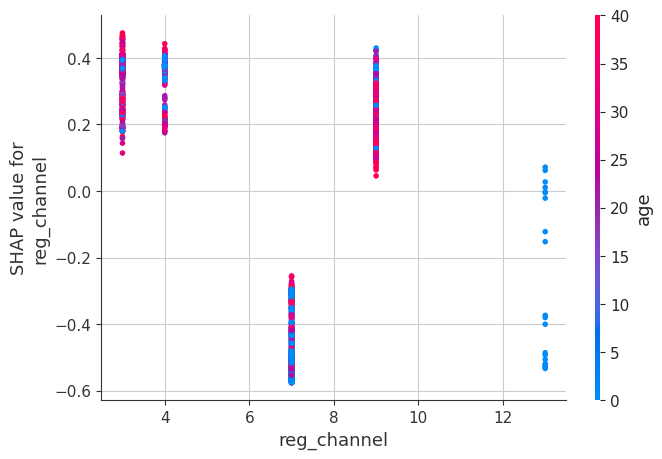

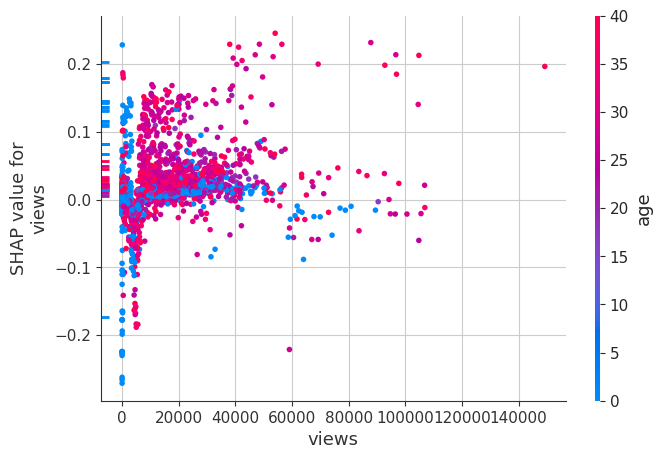

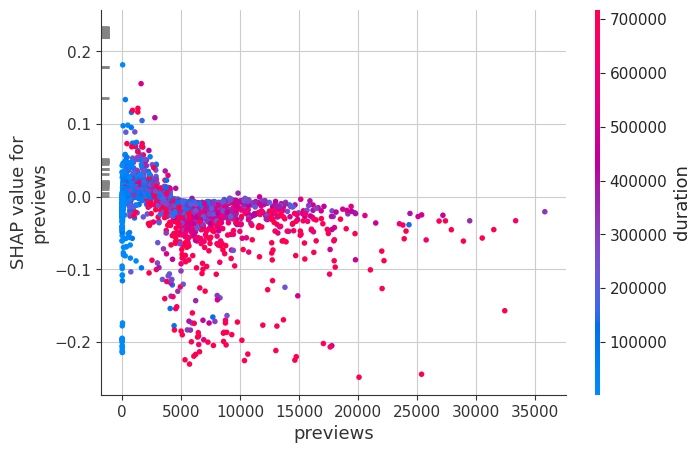

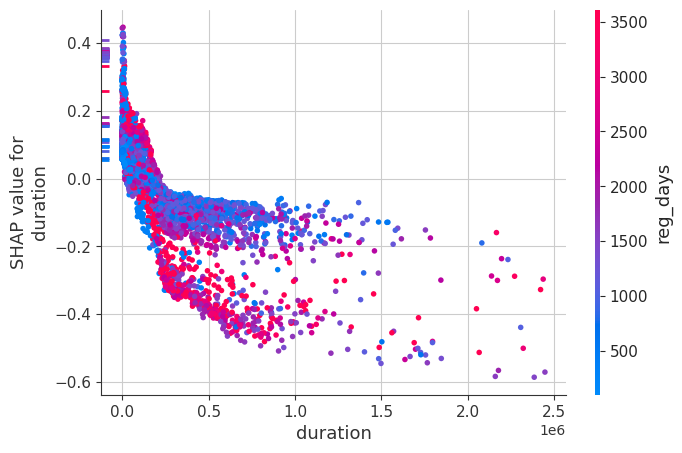

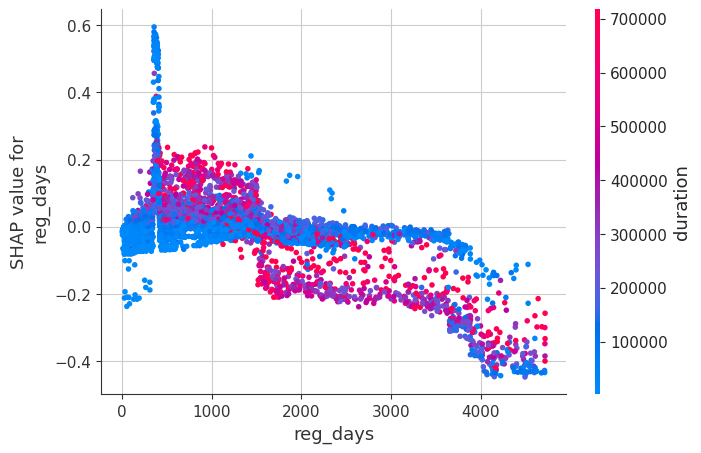

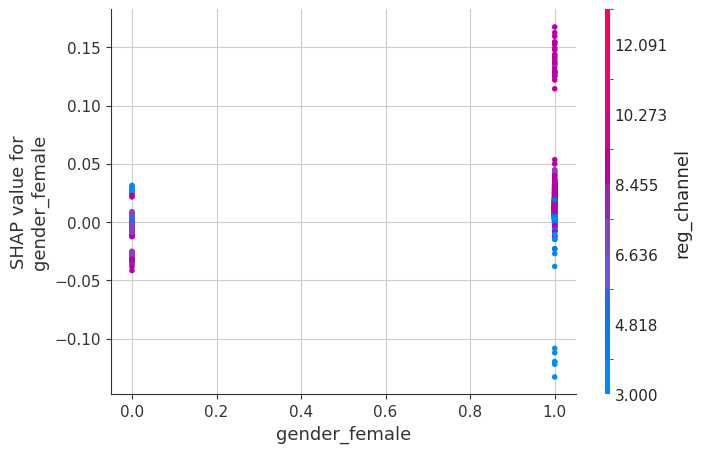

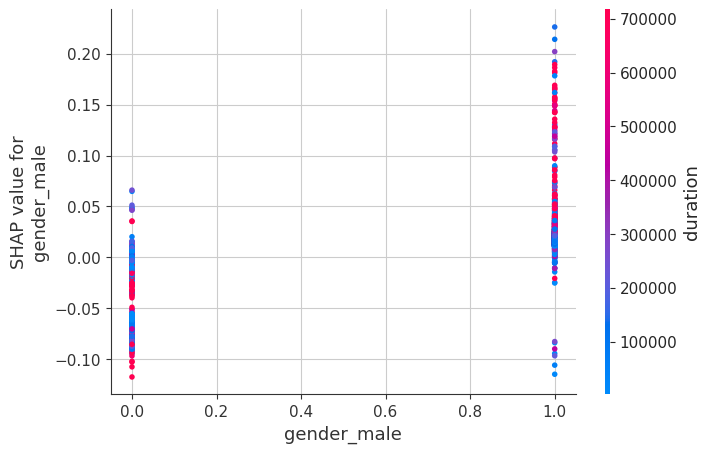

In [39]:
for name in x_train.columns:
    shap.dependence_plot(name,shap_values.values,x_train)

## Insights from Catboost

* location: there is some separation between higher and lower outcome likelihoods, depending on duration. Long durations associated with lower outcomes for given location.
* age: increasing age associated with decreasing outcome likelihood, with steep decline above 50
* reg_channel: 6 and 13 have much lower likelihoods than the other channels
* views: likelihood of outcome deccreases till about 8000, then comes back to about level on average.
* previews: likelihood of outcome increases till about 2000, then declines till about 5000, and levels off thereafter
* duration: increasing duration associated with decreasing outcome likelihood, with slope changing around 0.1; clear separation in this plot across reg_days, with higher values yielding lower outcome likelihoods given duration
* reg_days: unusual spike around 400 or so; similar separation as in duration
* gender: males have slightly higher likelihood than females, with some clustering for males

# LSTM Model

This is the identical code from Katsov's example. 

In [4]:
#
# Basic feature engineering
#
profiles = df_users.join(df_logs.drop(columns='date').groupby('uid').agg('sum'), on='uid')
profiles['reg_days'] = (profiles['reg_date'].max() - profiles['reg_date']).dt.days
profiles = pd.get_dummies(profiles, columns=['gender'])
profiles.drop(columns=['reg_date'], inplace=True)

#
# Feature engineering for Keras
#
x, y = profiles[['location', 'age', 'reg_channel', 'reg_days', 'gender_female', 'gender_male']], profiles['outcome']
x = pd.get_dummies(x, columns=['reg_channel'])
x = pd.get_dummies(x, columns=['location'])

#
# Column-wise normalization
#
normalize(x, x.columns)

print_df(x)

+-------+------------+------------+-----------------+---------------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
|   uid | age        | reg_days   |   gender_female |   gender_male |   reg_channel_3 |   reg_channel_4 |   reg_channel_7 |   reg_channel_9 |   reg_channel_13 | ...   |
|-------+------------+------------+-----------------+---------------+-----------------+-----------------+-----------------+-----------------+------------------+-------|
|     0 | 0.07033... | 0.18147... |               1 |             0 |               1 |               0 |               0 |               0 |                0 | ...   |
|     1 | 0.09730... | 0.83230... |               1 |             0 |               0 |               0 |               0 |               1 |                0 | ...   |
|     2 | 0.07737... | 0.76807... |               0 |             1 |               0 |               0 |               0 |               1 |              

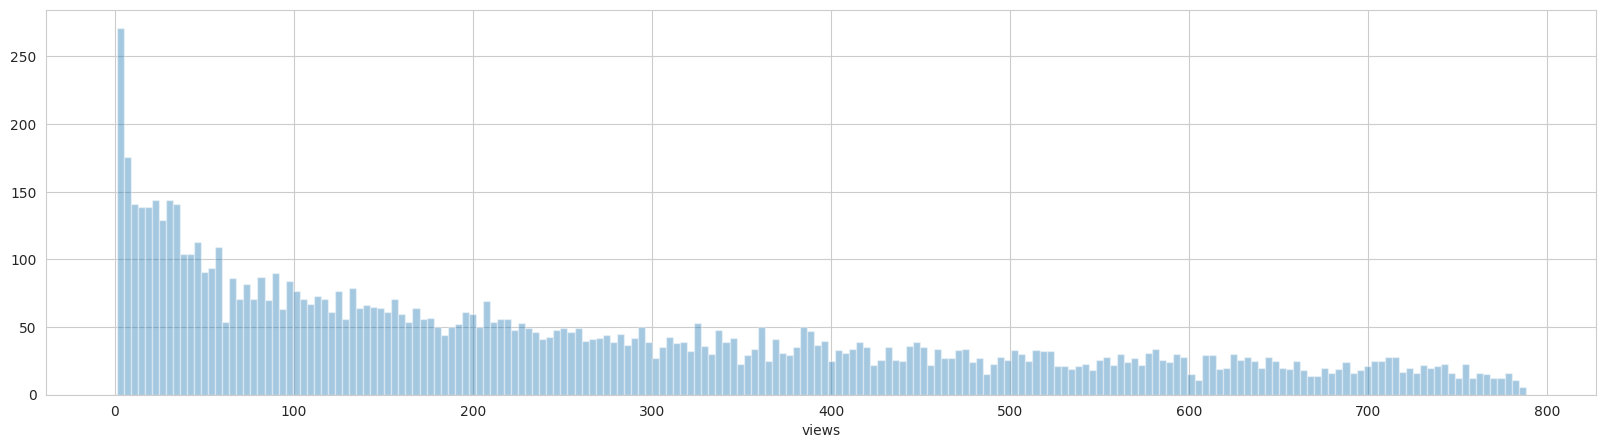

In [47]:
#
# plot how the number of activity records per user is distributed 
#
plt.figure(figsize=(20, 5));
sns.distplot(df_logs.groupby('uid').count()['views'], bins = 200, kde = False);

In [5]:
#
# aggregate daily activity records into buckets (e.g. weekly) and normalize
#
df_logs['time_bucket'] = -((df_logs['date'].max() - df_logs['date']).dt.days / 7).astype(int)
df_logs_weekly = df_logs.groupby(['uid', 'time_bucket']).sum()
normalize(df_logs_weekly, df_logs_weekly.columns)
print_df(df_logs_weekly)

+-----------+------------+------------+------------+
|           | views      | previews   | duration   |
|-----------+------------+------------+------------|
| (0, -104) | 0.02357... | 0.05372... | 0.15709... |
| (0, -103) | 0.01817... | 0.05228... | 0.11822... |
| (0, -102) | 0.01799... | 0.05314... | 0.12069... |
| (0, -101) | 0.00971... | 0.05458... | 0.07107... |
| (0, -100) | 0.00503... | 0.04108... | 0.04295... |
| (0, -99)  | 0.00233... | 0.01407... | 0.01507... |
| (0, -98)  | 0.00503... | 0.02872... | 0.05008... |
| (0, -97)  | 0.01421... | 0.02729... | 0.09132... |
| (0, -96)  | 0.00143... | 0.00861... | 0.01189... |
| (0, -95)  | 0.01097... | 0.02212... | 0.06178... |
+-----------+------------+------------+------------+
507445 rows x 3 columns


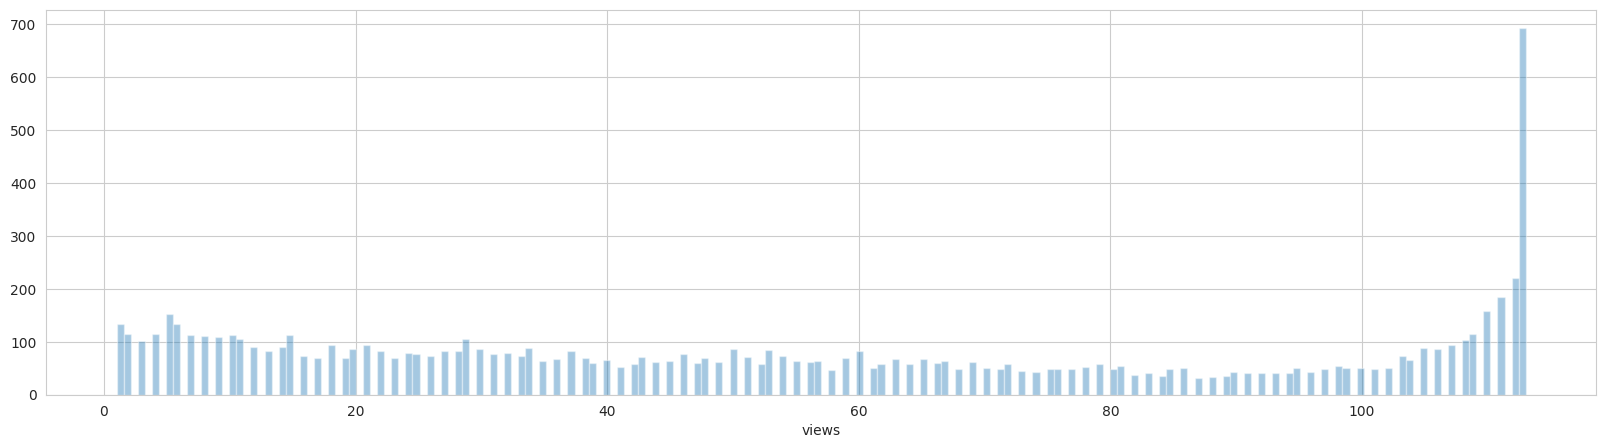

In [49]:
#
# plot how the number of weekly activity records per user is distributed 
#
plt.figure(figsize=(20, 5));
sns.distplot(df_logs_weekly.groupby('uid').count()['views'], bins = 200, kde = False);

In [6]:
#
# Feature engineering for Keras: 3D tensor for LSTM (n_users x events_per_user x n_features_per_event)
#
a3d = df_logs_weekly.sort_values(['uid', 'time_bucket']).groupby('uid').apply(pd.DataFrame.to_numpy)
n_users = len(df_users)
events_per_user = df_logs_weekly.groupby('uid').count()['views'].max()
n_features = len(df_logs_weekly.columns)
x3d = np.zeros((n_users, events_per_user, n_features))
for uid in df_users.index:
    if uid in df_logs.index:
        n_events = min(events_per_user, len(a3d[uid]))
        x3d[uid, -n_events:, :] = a3d[uid][-n_events:, :]
        
print(f'Input tensor shapes: x3d {x3d.shape}, x {x.shape}, y {y.shape}')

#
# Train-test split
#
x3d_train, x3d_test, x_train, x_test, y_train, y_test = train_test_split(x3d, x, y, test_size = 0.25, random_state = 1)

Input tensor shapes: x3d (8979, 113, 3), x (8979, 30), y (8979,)


Epoch 1/10
421/421 [==============================] - 12s 24ms/step - loss: 0.6398 - accuracy: 0.6482 - val_loss: 0.6202 - val_accuracy: 0.6639
Epoch 2/10
421/421 [==============================] - 9s 23ms/step - loss: 0.6181 - accuracy: 0.6680 - val_loss: 0.6117 - val_accuracy: 0.6766
Epoch 3/10
421/421 [==============================] - 9s 21ms/step - loss: 0.6106 - accuracy: 0.6766 - val_loss: 0.6082 - val_accuracy: 0.6749
Epoch 4/10
421/421 [==============================] - 9s 22ms/step - loss: 0.6041 - accuracy: 0.6853 - val_loss: 0.5930 - val_accuracy: 0.6917
Epoch 5/10
421/421 [==============================] - 9s 23ms/step - loss: 0.5908 - accuracy: 0.6971 - val_loss: 0.5823 - val_accuracy: 0.6960
Epoch 6/10
421/421 [==============================] - 10s 23ms/step - loss: 0.5747 - accuracy: 0.7049 - val_loss: 0.5634 - val_accuracy: 0.7171
Epoch 7/10
421/421 [==============================] - 9s 23ms/step - loss: 0.5618 - accuracy: 0.7176 - val_loss: 0.5480 - val_accuracy: 0.72

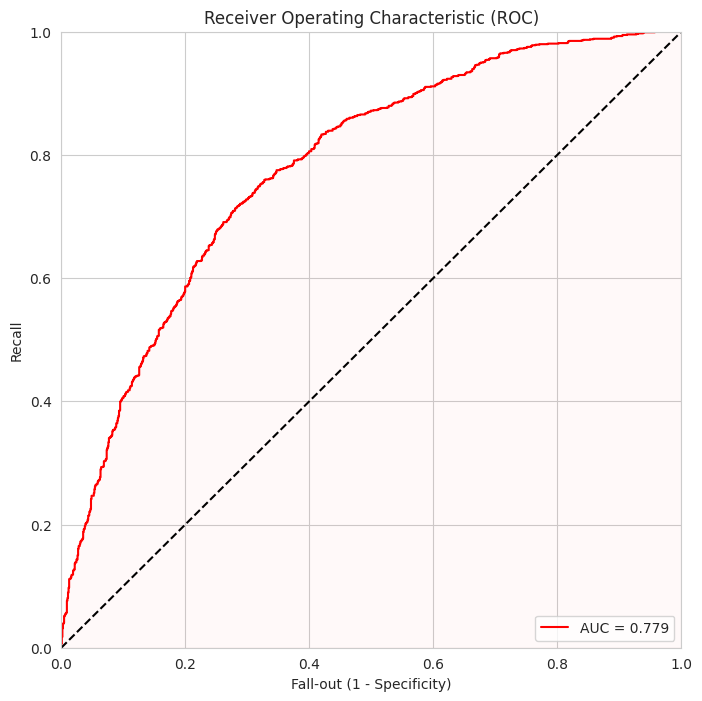

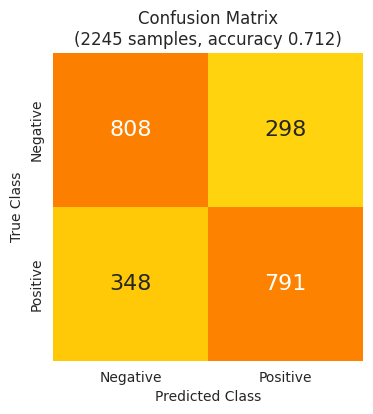

In [51]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

## Experimentation with Different Types of DL Models

I experimented with changing the hyperparameters for my own edification.

### User Profile Tower Width

Setting the Dense layer in the Profile tower to 32 units wide.

2023-04-28 20:27:27.404894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 20:27:27.405473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 20:27:27.405953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 20:27:27.406549: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in othe

Epoch 1/10


2023-04-28 20:27:29.729788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-28 20:27:29.760132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-04-28 20:27:29.784609: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa78a18e9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-28 20:27:29.784661: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-04-28 20:27:29.788350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-28 20:27:29.864757: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

421/421 [==============================] - 12s 24ms/step - loss: 0.6341 - accuracy: 0.6614 - val_loss: 0.6199 - val_accuracy: 0.6694
Epoch 2/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6187 - accuracy: 0.6727 - val_loss: 0.6118 - val_accuracy: 0.6748
Epoch 3/10
421/421 [==============================] - 10s 23ms/step - loss: 0.6131 - accuracy: 0.6739 - val_loss: 0.6058 - val_accuracy: 0.6800
Epoch 4/10
421/421 [==============================] - 10s 23ms/step - loss: 0.6066 - accuracy: 0.6767 - val_loss: 0.6052 - val_accuracy: 0.6855
Epoch 5/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5972 - accuracy: 0.6859 - val_loss: 0.5834 - val_accuracy: 0.6950
Epoch 6/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5803 - accuracy: 0.7008 - val_loss: 0.5635 - val_accuracy: 0.7134
Epoch 7/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5649 - accuracy: 0.7121 - val_loss: 0.5613 - val_accuracy: 0.7208
Epo

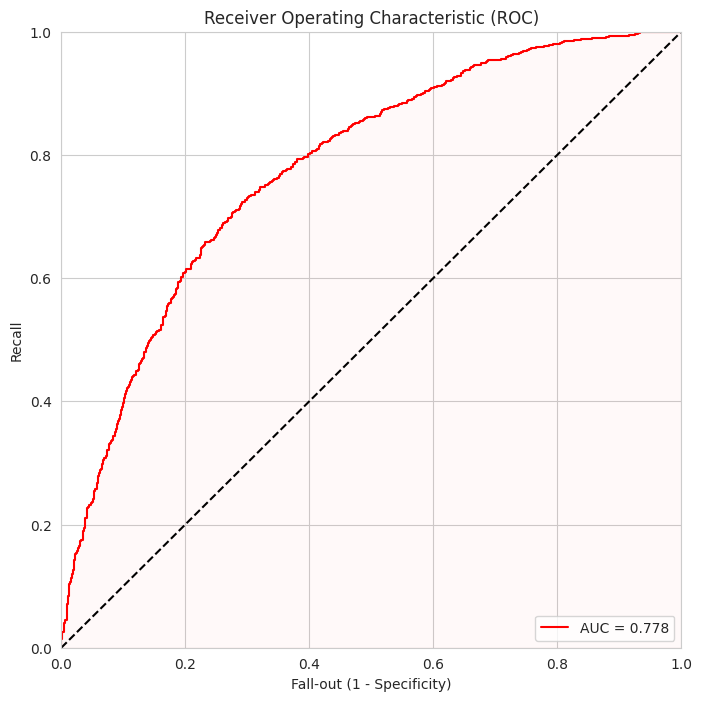

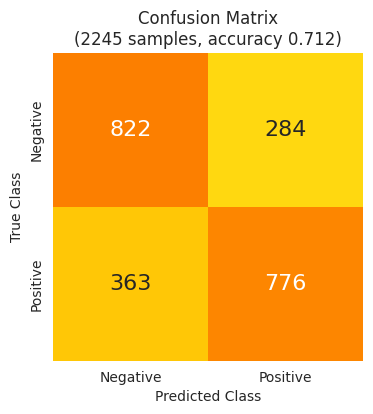

In [7]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(32, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

## Narrow user profile tower

Epoch 1/10
421/421 [==============================] - 12s 24ms/step - loss: 0.6580 - accuracy: 0.6383 - val_loss: 0.6240 - val_accuracy: 0.6702
Epoch 2/10
421/421 [==============================] - 10s 23ms/step - loss: 0.6209 - accuracy: 0.6678 - val_loss: 0.6163 - val_accuracy: 0.6739
Epoch 3/10
421/421 [==============================] - 9s 22ms/step - loss: 0.6098 - accuracy: 0.6769 - val_loss: 0.6020 - val_accuracy: 0.6861
Epoch 4/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5949 - accuracy: 0.6928 - val_loss: 0.5865 - val_accuracy: 0.6959
Epoch 5/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5746 - accuracy: 0.7078 - val_loss: 0.5577 - val_accuracy: 0.7181
Epoch 6/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5596 - accuracy: 0.7173 - val_loss: 0.5674 - val_accuracy: 0.7146
Epoch 7/10
421/421 [==============================] - 9s 22ms/step - loss: 0.5555 - accuracy: 0.7199 - val_loss: 0.5466 - val_accuracy: 0

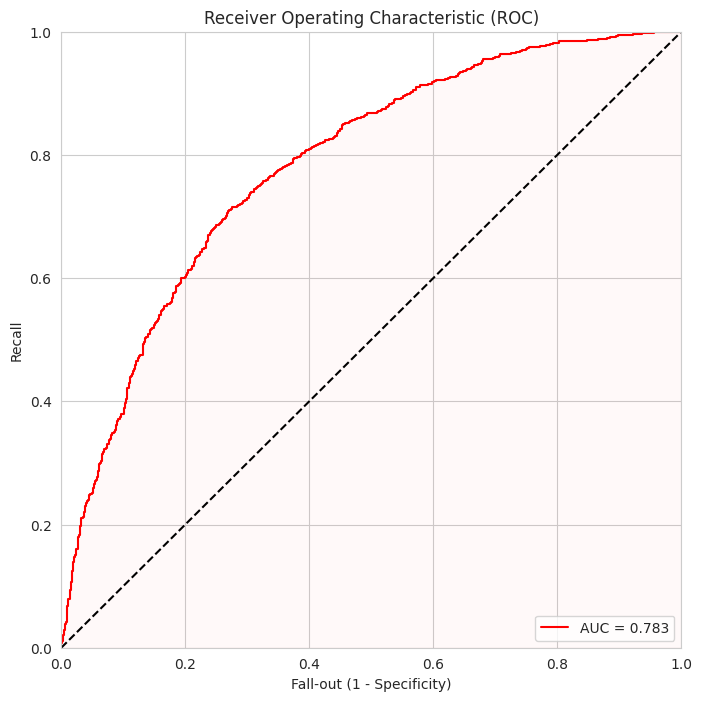

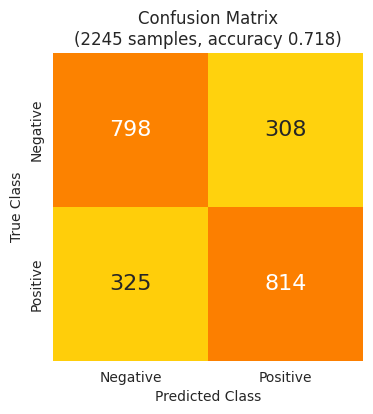

In [8]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(8, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

In [9]:
## Wider LSTM

Epoch 1/10
421/421 [==============================] - 13s 25ms/step - loss: 0.6393 - accuracy: 0.6552 - val_loss: 0.6153 - val_accuracy: 0.6739
Epoch 2/10
421/421 [==============================] - 10s 25ms/step - loss: 0.6148 - accuracy: 0.6718 - val_loss: 0.6084 - val_accuracy: 0.6785
Epoch 3/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6068 - accuracy: 0.6813 - val_loss: 0.6016 - val_accuracy: 0.6850
Epoch 4/10
421/421 [==============================] - 10s 25ms/step - loss: 0.5906 - accuracy: 0.6919 - val_loss: 0.5721 - val_accuracy: 0.7027
Epoch 5/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5680 - accuracy: 0.7079 - val_loss: 0.5525 - val_accuracy: 0.7201
Epoch 6/10
421/421 [==============================] - 10s 23ms/step - loss: 0.5559 - accuracy: 0.7204 - val_loss: 0.5476 - val_accuracy: 0.7210
Epoch 7/10
421/421 [==============================] - 9s 23ms/step - loss: 0.5515 - accuracy: 0.7186 - val_loss: 0.5406 - val_accuracy: 

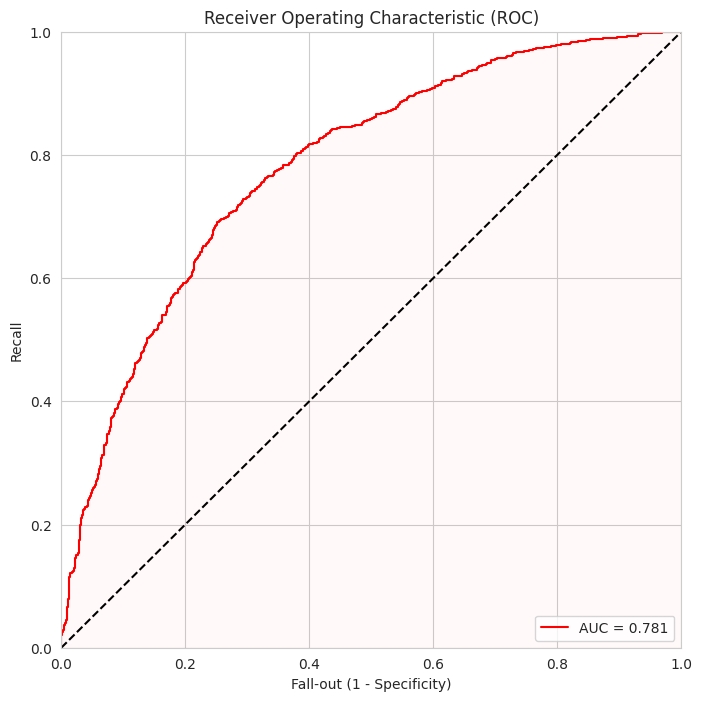

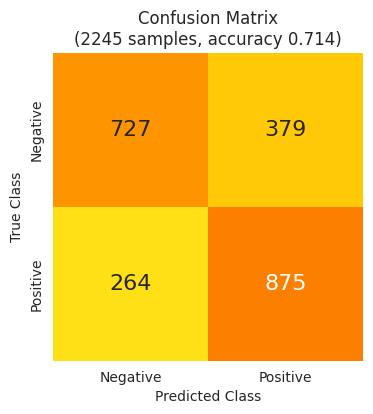

In [10]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(16, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

In [11]:
## Narrower LSTM

Epoch 1/10
421/421 [==============================] - 12s 24ms/step - loss: 0.6433 - accuracy: 0.6445 - val_loss: 0.6200 - val_accuracy: 0.6654
Epoch 2/10
421/421 [==============================] - 10s 23ms/step - loss: 0.6168 - accuracy: 0.6656 - val_loss: 0.6130 - val_accuracy: 0.6770
Epoch 3/10
421/421 [==============================] - 10s 23ms/step - loss: 0.6092 - accuracy: 0.6732 - val_loss: 0.6131 - val_accuracy: 0.6705
Epoch 4/10
421/421 [==============================] - 10s 23ms/step - loss: 0.6033 - accuracy: 0.6806 - val_loss: 0.5945 - val_accuracy: 0.6862
Epoch 5/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5937 - accuracy: 0.6925 - val_loss: 0.5817 - val_accuracy: 0.6994
Epoch 6/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5789 - accuracy: 0.7017 - val_loss: 0.5657 - val_accuracy: 0.7069
Epoch 7/10
421/421 [==============================] - 9s 21ms/step - loss: 0.5655 - accuracy: 0.7097 - val_loss: 0.5611 - val_accuracy: 

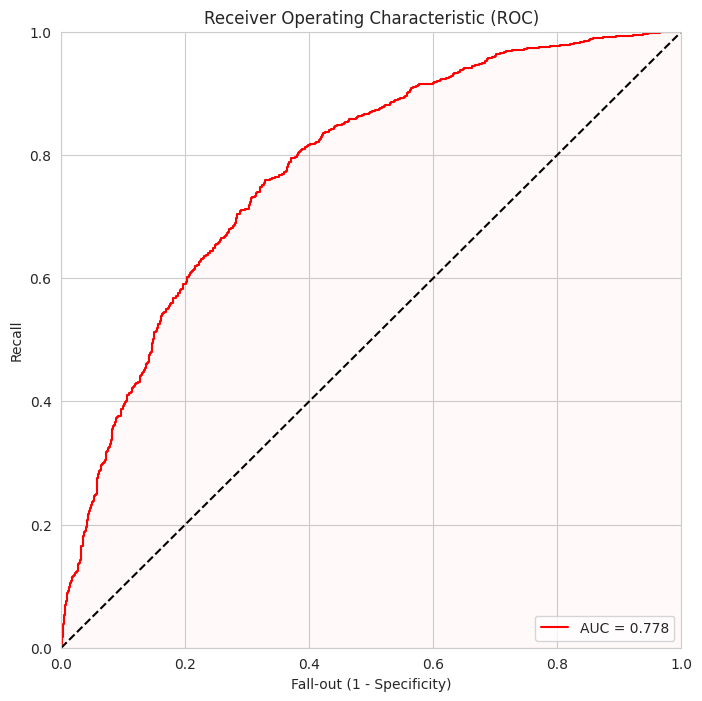

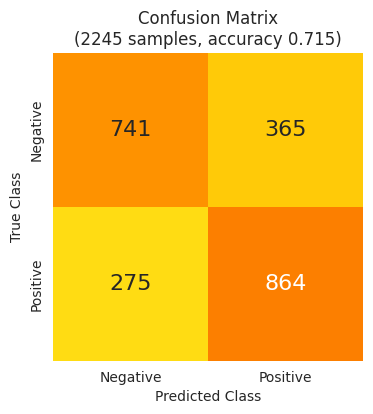

In [12]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(4, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

## Less model depth

Epoch 1/10
421/421 [==============================] - 12s 24ms/step - loss: 0.6489 - accuracy: 0.6546 - val_loss: 0.6219 - val_accuracy: 0.6668
Epoch 2/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6190 - accuracy: 0.6697 - val_loss: 0.6129 - val_accuracy: 0.6740
Epoch 3/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6123 - accuracy: 0.6782 - val_loss: 0.6078 - val_accuracy: 0.6794
Epoch 4/10
421/421 [==============================] - 10s 24ms/step - loss: 0.6071 - accuracy: 0.6788 - val_loss: 0.6024 - val_accuracy: 0.6849
Epoch 5/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5995 - accuracy: 0.6862 - val_loss: 0.5908 - val_accuracy: 0.6926
Epoch 6/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5879 - accuracy: 0.6977 - val_loss: 0.5774 - val_accuracy: 0.6987
Epoch 7/10
421/421 [==============================] - 10s 24ms/step - loss: 0.5738 - accuracy: 0.7057 - val_loss: 0.5625 - val_accuracy:

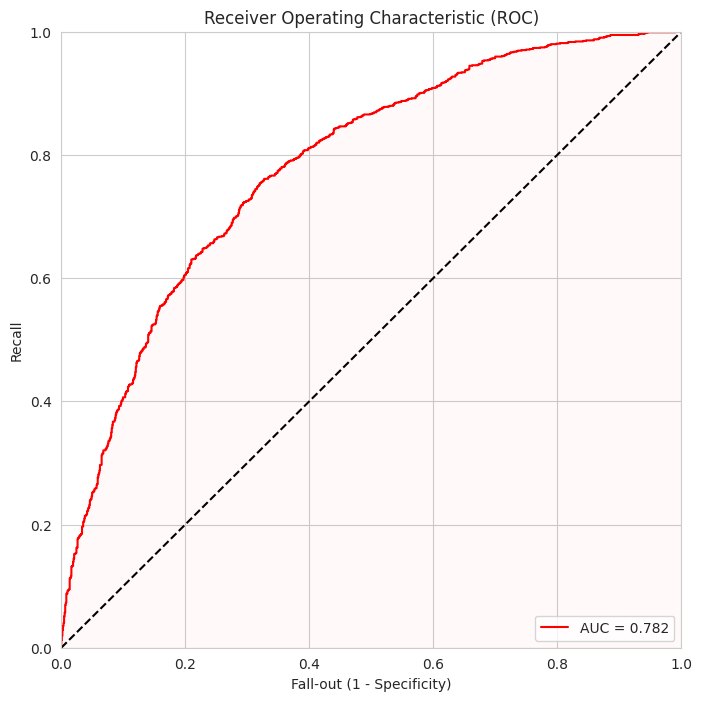

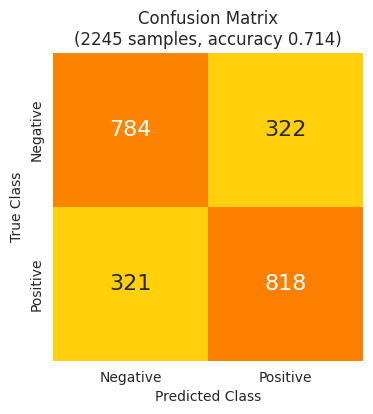

In [13]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
#dense_top_1 = Dense(32, activation='relu')(combined)
#dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_2 = Dense(16, activation='relu')(combined)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

# LSTM with Attention

Epoch 1/10
421/421 [==============================] - 15s 28ms/step - loss: 0.6419 - accuracy: 0.6524 - val_loss: 0.6183 - val_accuracy: 0.6674
Epoch 2/10
421/421 [==============================] - 12s 28ms/step - loss: 0.6169 - accuracy: 0.6639 - val_loss: 0.6155 - val_accuracy: 0.6681
Epoch 3/10
421/421 [==============================] - 12s 30ms/step - loss: 0.6127 - accuracy: 0.6751 - val_loss: 0.6137 - val_accuracy: 0.6804
Epoch 4/10
421/421 [==============================] - 11s 27ms/step - loss: 0.6097 - accuracy: 0.6758 - val_loss: 0.6054 - val_accuracy: 0.6821
Epoch 5/10
421/421 [==============================] - 11s 27ms/step - loss: 0.6080 - accuracy: 0.6810 - val_loss: 0.6052 - val_accuracy: 0.6844
Epoch 6/10
421/421 [==============================] - 12s 29ms/step - loss: 0.6054 - accuracy: 0.6846 - val_loss: 0.6025 - val_accuracy: 0.6874
Epoch 7/10
421/421 [==============================] - 12s 29ms/step - loss: 0.6047 - accuracy: 0.6862 - val_loss: 0.6004 - val_accuracy:

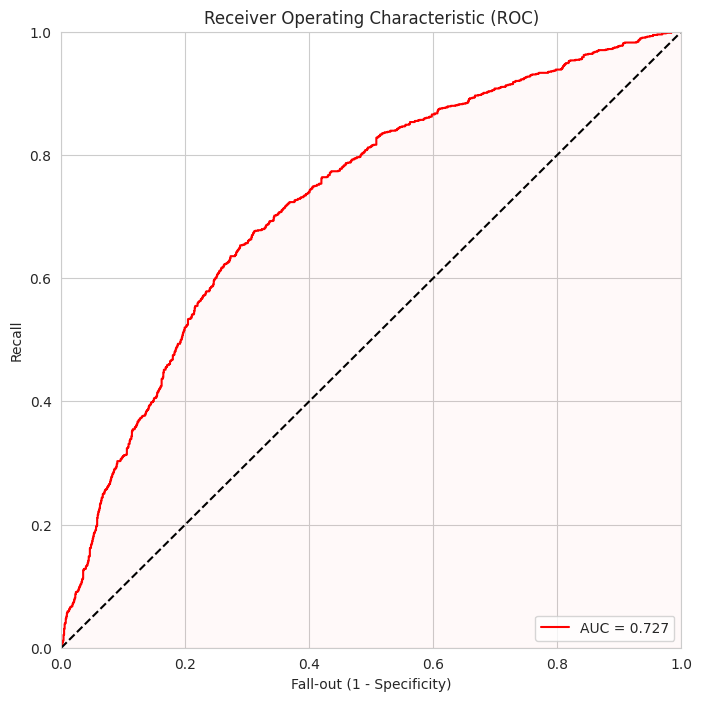

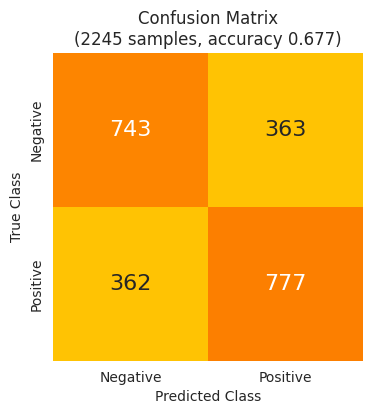

In [23]:
#
# Model parameters
#
hidden_units = 8

#
# Model specification
#
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

lstm_tower = Model(inputs=input_logs, outputs=weighted_activations)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top = Dense(32, activation='relu')(combined)
prob_outcome = Dense(1, activation='sigmoid')(dense_top)
model_lstm_attn = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

#
# Model training
#
model_lstm_attn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm_attn.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm_attn.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

#
# Model evaluation
#
predictions_lstm_a_prob = model_lstm_attn.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_a_prob)
plot_confusion_matrix(y_test, predictions_lstm_a_prob, ['Negative', 'Positive'])

In [ ]:
#
# Attention weights analysis
#
attention_model = Model(inputs=model_lstm_attn.input, outputs=model_lstm_attn.get_layer('attention_weigths').output)
a = attention_model.predict([x3d_test, x_test])
print(f'Attention weights matrix: {a.shape[0]} users x {a.shape[1]} weights')

In [ ]:
uid = 30
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(20 * a[uid, :], label='Attention weights', linewidth=5, alpha=0.5)
for i, column in zip(range(n_features), ['Views', 'Items', 'Duration', 'Previews']):
    ax.plot(x3d_test[uid][:, i], label=column)
ax.legend();

# GLM

Since I have considerable experience with GLMs, particularly GAMs, I wanted to see how a traditional GLM coped with this dataset. Sometimes, a GLM can do well enough to act as a proxy model to assist stakeholders to better understand what is going on. Based on the SHAP values, splines are clearly needed, and I used the `mgcv` packages.

In this case, the GAM has trouble coping with some of the features that the boosted model was able to deal with. Both age and reg_days are not handled well by the GAM. The other effects are nonetheless reasonably well captured.

Impressively, the GAM has an accuracy of 0.699 on a testing subset. While worse than the LSTM models, it is markedly better than the boosted decision tree models.

In [14]:
%load_ext rpy2.ipython

In [20]:
%%R -i profiles -w 5 -h 5 --units in -r 200

library(data.table)
library(mgcv)
library(flextable)
library(tidyverse)

setDT(profiles)

profiles[,
    gender:=ifelse(gender_male==1,"M",ifelse(gender_female==1,"F","U"))]

factor_cols <- c(
  "gender",
  "location",
  "reg_channel"
)

profiles[,
    (factor_cols):=lapply(.SD,factor),
    .SDcols=factor_cols]

profiles[,
        Train:=runif(nrow(.SD)) < 0.7]



      location age reg_channel outcome views previews duration reg_days
   1:       15  17           3       1  2677     4600    86544      856
   2:       13  40           9       0 23010     7136   635905     3926
   3:       14  23           9       1 52578     5000  1325654     3623
   4:        1  19           3       1  5422     2072   145091      844
   5:        1   0           9       1 20754     7240   509117      838
  ---                                                                  
8975:       13  18           4       0  8165     2118   205343      473
8976:        3  24           3       1  5573     1006   146466     1006
8977:       13  30           9       0 19750     6759   510172     2977
8978:        1  17           3       1  4213     1734   114193      906
8979:       13  25           9       0  9547     2651   249676      520
      gender_female gender_male gender Train
   1:             1           0      F  TRUE
   2:             1           0      F  TRUE
 

In [21]:
%%R 

mod.profs <- gam(
  outcome ~ location +
    s(age,k=20) +
    reg_channel +
    s(views,k=20) +
    s(previews,k=20) +
    s(duration,k=20) +
    s(reg_days,k=20) +
    gender,
  data=profiles[Train==T],
  family=binomial
)

In [22]:
%%R

profiles[,ypred:=predict(mod.profs,newdata=.SD,type="response")]

profiles[Train==T & !is.na(ypred),
         sum(ifelse(
           round(ypred,0)==outcome,1,0))/.N]

[1] 0.6997272


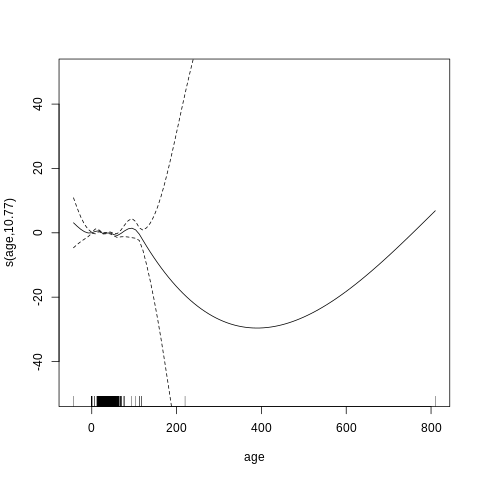

In [14]:
%%R

plot(mod.profs,select=1,ylim=c(-50,50))

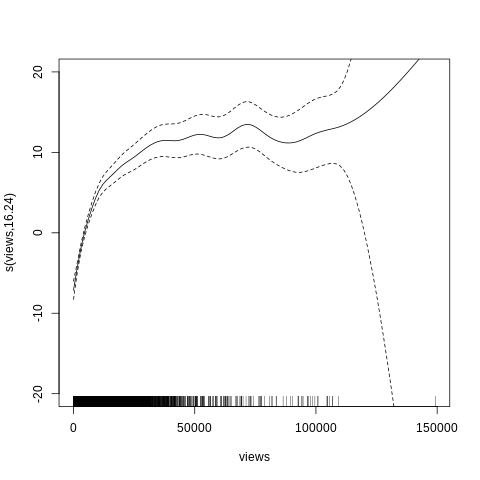

In [13]:
%%R

plot(mod.profs,select=2,ylim=c(-20,20))

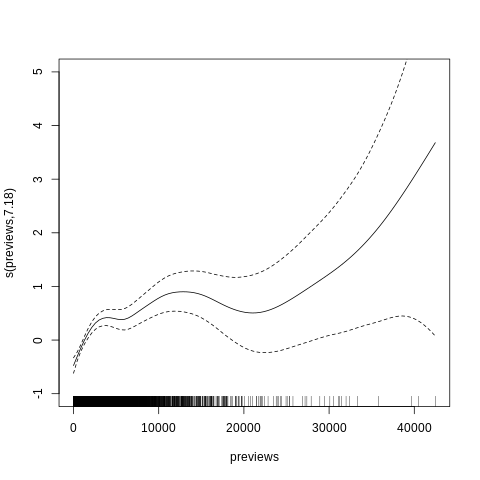

In [17]:
%%R

plot(mod.profs,select=3,ylim=c(-1,5))

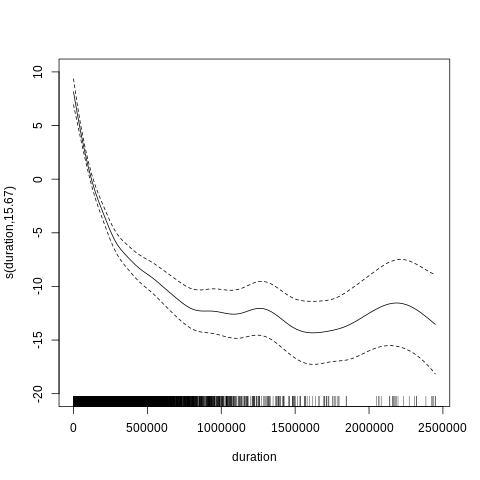

In [22]:
%%R

plot(mod.profs,select=4,ylim=c(-20,10))

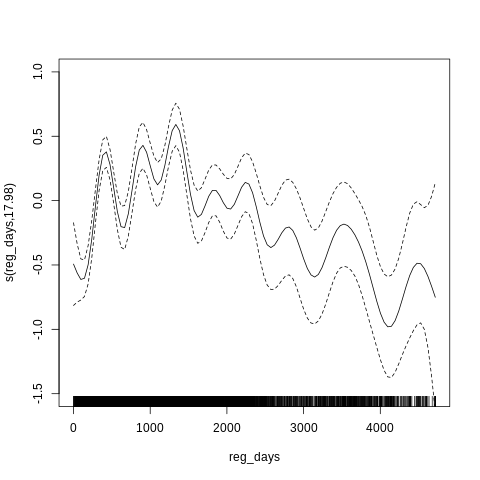

In [25]:
%%R

plot(mod.profs,select=5,ylim=c(-1.5,1))

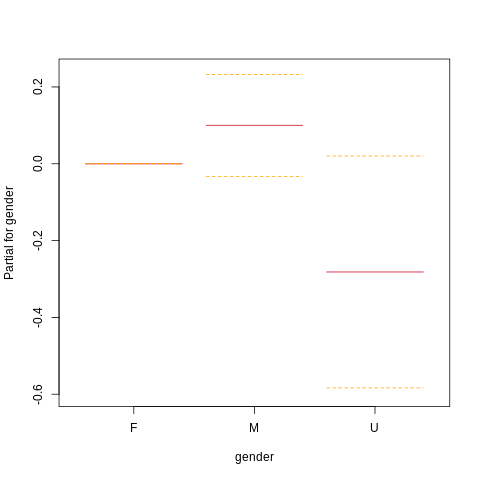

In [27]:
%%R

termplot(mod.profs,se=T,terms="gender")

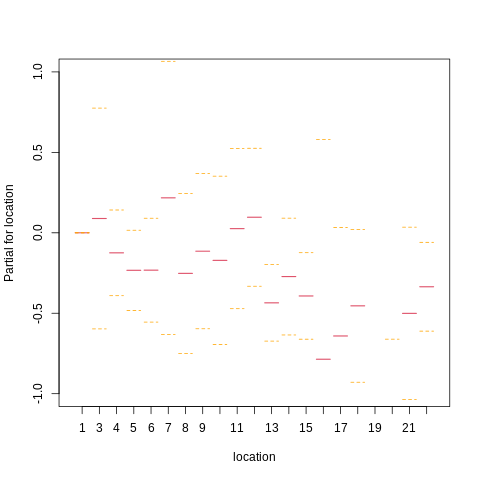

In [29]:
%%R

termplot(mod.profs,se=T,terms="location",ylim=c(-1,1))

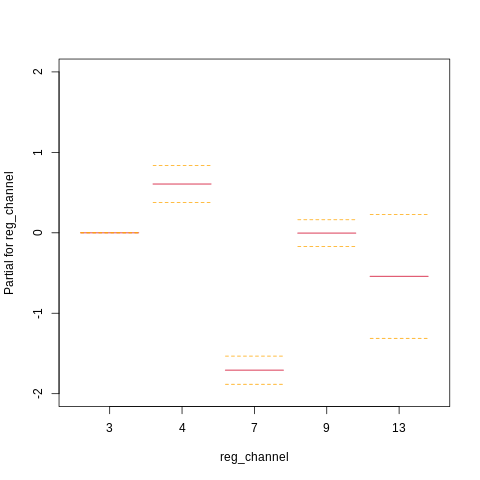

R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



In [31]:
%%R

termplot(mod.profs,se=T,terms="reg_channel",ylim=c(-2,2))